## Importing  Libraries

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from PIL import Image

import time
import os
import datetime
import copy
import shutil
import random

In [171]:
train_df[train_df['image_id']==20312]

,image_id,label,image_width,image_height,is_tma
169,20312,HGSC,61275,43983,False


In [9]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print('device =',device)

device = cuda:0


## Loading the Data

In [10]:
train = pd.read_csv(r"/kaggle/input/UBC-OCEAN/train.csv")
test = pd.read_csv(r"/kaggle/input/UBC-OCEAN/test.csv")

In [11]:
train.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


# Dataset Organization

In [12]:
tma = train[train["is_tma"] == True]
no_tma = train[train["is_tma"] == False]

no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in no_tma['image_id']]
tma['image_id_path'] = [f"{i}.png" for i in tma['image_id']]
test['image_id_path'] = [f"{i}_thumbnail.png" for i in test['image_id']]

/tmp/ipykernel_42/199507652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in no_tma['image_id']]
/tmp/ipykernel_42/199507652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tma['image_id_path'] = [f"{i}.png" for i in tma['image_id']]


In [85]:
test

,image_id,image_width,image_height,image_id_path
0,41,28469,16987,41_thumbnail.png


In [13]:
random_rows = train.sample(n=10) 
print(random_rows)
# Save the selected random rows as a DataFrame
test_df = pd.DataFrame(random_rows)
test_df['image_id_path'] = [f"{i}.png" if i in tma['image_id'].values else f"{i}_thumbnail.png" for i in test_df['image_id']]
test_df

     image_id label  image_width  image_height  is_tma
224     27851    EC        68648         30510   False
246     30272    CC        35785         31903   False
203     25331    MC        61896         47117   False
260     31333  HGSC        65543         30023   False
256     30986    MC        66911         49395   False
408     48550    MC        32431         25393   False
278     34277  LGSC        65805         35570   False
440     52438  HGSC        33243         45695   False
189     22489    CC        26703         28946   False
23       2666    EC        53270         44031   False


,image_id,label,image_width,image_height,is_tma,image_id_path
224,27851,EC,68648,30510,False,27851_thumbnail.png
246,30272,CC,35785,31903,False,30272_thumbnail.png
203,25331,MC,61896,47117,False,25331_thumbnail.png
260,31333,HGSC,65543,30023,False,31333_thumbnail.png
256,30986,MC,66911,49395,False,30986_thumbnail.png
408,48550,MC,32431,25393,False,48550_thumbnail.png
278,34277,LGSC,65805,35570,False,34277_thumbnail.png
440,52438,HGSC,33243,45695,False,52438_thumbnail.png
189,22489,CC,26703,28946,False,22489_thumbnail.png
23,2666,EC,53270,44031,False,2666_thumbnail.png


In [14]:
# Dropping the random samples generated for testing from the training data:
train_df=train.drop(random_rows.index)
train_df

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [15]:
tma

,image_id,label,image_width,image_height,is_tma,image_id_path
2,91,HGSC,3388,3388,True,91.png
37,4134,MC,2964,2964,True,4134.png
76,8280,HGSC,2964,2964,True,8280.png
83,9200,MC,3388,3388,True,9200.png
112,13568,LGSC,2964,2964,True,13568.png
149,17637,HGSC,2964,2964,True,17637.png
176,21020,MC,3388,3388,True,21020.png
236,29084,LGSC,3388,3388,True,29084.png
263,31594,EC,3388,3388,True,31594.png
288,35565,MC,2964,2964,True,35565.png


In [89]:
train = pd.concat([tma,no_tma],ignore_index=True)

# Preprocessing the Data

In [16]:

# Encode the labels
laben = LabelEncoder()
labels = train['label']
laben.fit(labels)
train['label'] = laben.transform(labels)

In [17]:
train.head()

,image_id,label,image_width,image_height,is_tma
0,4,2,23785,20008,False
1,66,3,48871,48195,False
2,91,2,3388,3388,True
3,281,3,42309,15545,False
4,286,1,37204,30020,False


In [92]:
train.label.unique() # Viewing the classes after enocding

array([2, 4, 3, 1, 0])

## Defining a class to load the images without applying any transformations

In [18]:
class ImageLoader(Dataset):
    def __init__(self, data, root_path, train_thumbnails, train_images, transform=None):
        self.data = data
        self.root_path = root_path
        self.train_thumbnails = train_thumbnails
        self.train_images = train_images
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        is_tma = self.data.iloc[idx]['is_tma']
        img_name = self.data.iloc[idx, -1]
    
        if is_tma:
            path = os.path.join(root_path, self.train_images, img_name)
        else:
            path = os.path.join(root_path, self.train_thumbnails, img_name)

        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.data.iloc[idx, 1])
        
        return image, label

In [19]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

root_path = "/kaggle/input/UBC-OCEAN/"
train_thumbs = "train_thumbnails/"
train_images = "train_images/"

test_thumbs = "test_thumbnails/"
test_images = "test_images/"

dataset = ImageLoader(train, root_path, train_thumbs, train_images, train_transform)

train_ratio = 0.8
valid_ratio = 0.2

train_size = int(train_ratio * len(train))
valid_size = len(train) - train_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_data_loader = DataLoader(train_data, batch_size = 16, shuffle = False, num_workers = 4)
valid_data_loader = DataLoader(valid_data, batch_size = 16, shuffle = False, num_workers = 4)
classes = laben.classes_

The mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225] are commonly used values derived from the ImageNet dataset. These values are widely adopted as a standard for normalization in various deep learning tasks involving image classification, as they have been found to work well across different datasets and models.

In [95]:
classes

array(['CC', 'EC', 'HGSC', 'LGSC', 'MC'], dtype=object)

## Model Training

# Model 1

### **Model used:** Resnet 50 <br>
**Hyper-parameters involved:**
1. n_epochs: Number of epochs for training the model. Value: 29
2. total_step: Total number of batches in the training data loader Value: Length of the training data loader (len(train_data_loader))
3. lr: Learning rate for the optimizer (SGD)Value: 0.0005
4. momentum: Momentum parameter for the optimizer (SGD) Value: 0.8
5. batch_size: Batch size for training Value: 16




In PyTorch, F refers to the torch.nn.functional module, which provides a collection of functions that operate on tensors and are used in neural network layers. This module contains various activation functions, loss functions, and other operations commonly used in deep learning.

- enumerate(train_data_loader): This function returns an iterator that yields pairs of (batch_index, batch_data) where batch_index is the index of the batch and batch_data is a tuple containing the input data and target labels for that batch.
- batch_idx: Represents the index of the current batch.
- (data_, target_): Represents a batch of input data (data_) and corresponding target labels (target_).

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 29
total_step = len(train_data_loader)

# ResNet50 model
model = models.resnet50(pretrained=True)

# freeze all parameters used
for param in model.parameters():
    param.requires_grad = False

# modify the final layer for the new classification task
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model = model.to(device)

# define optimizer and loss criteria
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.8)
weights_filename = 'baseline_resnet50.pt'

train_acc = []  
train_loss = [] 
val_acc = []  
val_loss = []  

# training the model
for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f'\nEpoch {epoch+1}:')
    
    for batch_idx, (data_, target_) in enumerate(train_data_loader):        
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 8 == 0:  
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, batch_idx, total_step, loss.item()))
    
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'Train Loss: {np.mean(train_loss):.3f}, Train Acc: {(100 * correct / total):.1f}%')
    
    # Validation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_data_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            
            val_running_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            val_correct += torch.sum(pred_t == target_t).item()
            val_total += target_t.size(0)
            
        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(valid_data_loader))

    print(f'Validation Loss: {np.mean(val_loss):.3f}, Validation Acc: {(100 * val_correct / val_total):.1f}%')
    
    # Save the model weights
    torch.save(model.state_dict(), weights_filename)

    # Set the model back to training mode
    model.train()

# Display final accuracy and loss
print(f'\nFinal Training Loss: {np.mean(train_loss):.3f}, Final Training Acc: {(100 * correct / total):.1f}%')
print(f'Final Validation Loss: {np.mean(val_loss):.3f}, Final Validation Acc: {(100 * val_correct / val_total):.1f}%')



Epoch 1:
Epoch [1/29], Step [0/27], Loss: 1.8253
Epoch [1/29], Step [8/27], Loss: 1.4732
Epoch [1/29], Step [16/27], Loss: 1.8266
Epoch [1/29], Step [24/27], Loss: 1.3524
Train Loss: 1.515, Train Acc: 35.1%
Validation Loss: 1.437, Validation Acc: 37.0%

Epoch 2:
Epoch [2/29], Step [0/27], Loss: 1.4186
Epoch [2/29], Step [8/27], Loss: 1.4153
Epoch [2/29], Step [16/27], Loss: 1.6457
Epoch [2/29], Step [24/27], Loss: 1.3839
Train Loss: 1.463, Train Acc: 42.6%
Validation Loss: 1.417, Validation Acc: 42.6%

Epoch 3:
Epoch [3/29], Step [0/27], Loss: 1.3981
Epoch [3/29], Step [8/27], Loss: 1.3854
Epoch [3/29], Step [16/27], Loss: 1.6527
Epoch [3/29], Step [24/27], Loss: 1.3178
Train Loss: 1.436, Train Acc: 42.8%
Validation Loss: 1.411, Validation Acc: 38.9%

Epoch 4:
Epoch [4/29], Step [0/27], Loss: 1.3343
Epoch [4/29], Step [8/27], Loss: 1.3631
Epoch [4/29], Step [16/27], Loss: 1.6119
Epoch [4/29], Step [24/27], Loss: 1.3085
Train Loss: 1.417, Train Acc: 42.6%
Validation Loss: 1.397, Valida

In [37]:
torch.save(model, 'trained_resnet50_model.pth')

# Evaluating Model 1's Performance

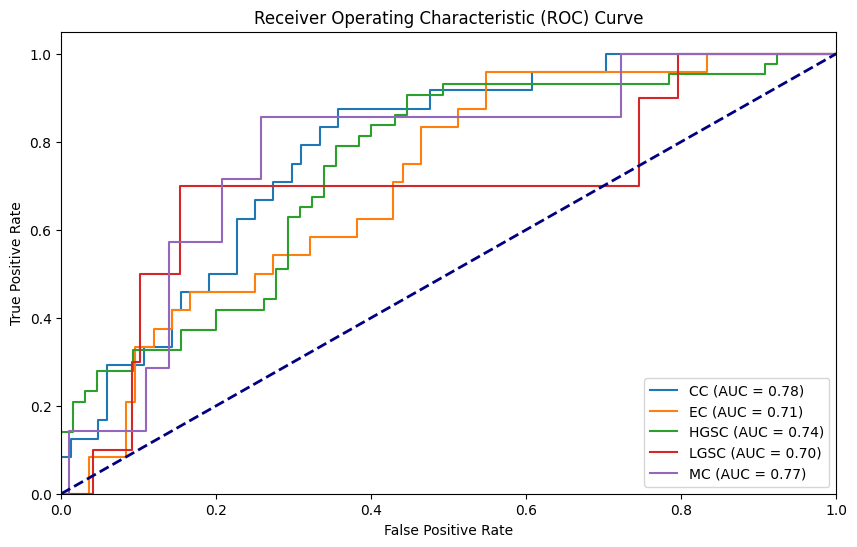

In [40]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted probabilities
true_labels = []
pred_probs = []

# Switch model to evaluation mode
model.eval()

# Iterate through the validation data loader to get predictions and true labels
with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        
        # Convert tensor to numpy array and append to lists
        true_labels.extend(target.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Initialize dictionary to store ROC AUC scores for each class
roc_auc_scores = {}

# Calculate ROC AUC scores for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


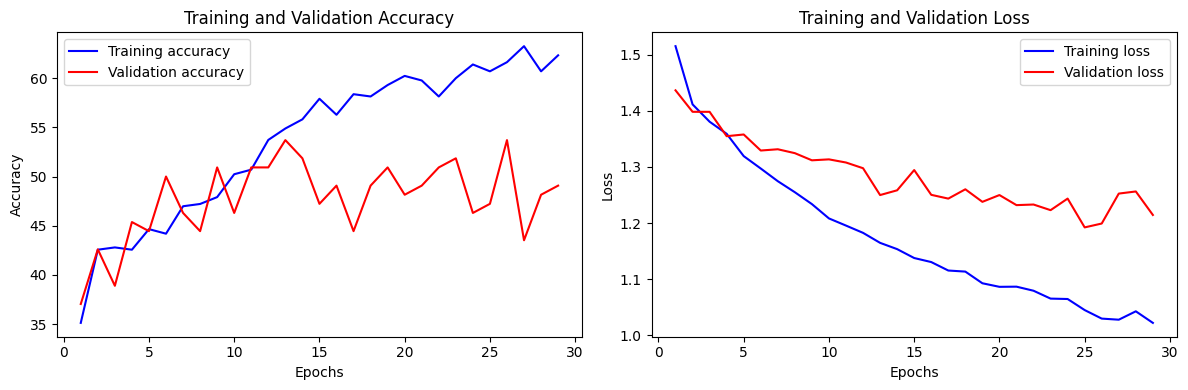

              precision    recall  f1-score   support

          CC       0.42      0.62      0.50        24
          EC       0.39      0.38      0.38        24
        HGSC       0.67      0.70      0.68        43
        LGSC       0.00      0.00      0.00        10
          MC       0.00      0.00      0.00         7

    accuracy                           0.50       108
   macro avg       0.29      0.34      0.31       108
weighted avg       0.44      0.50      0.47       108



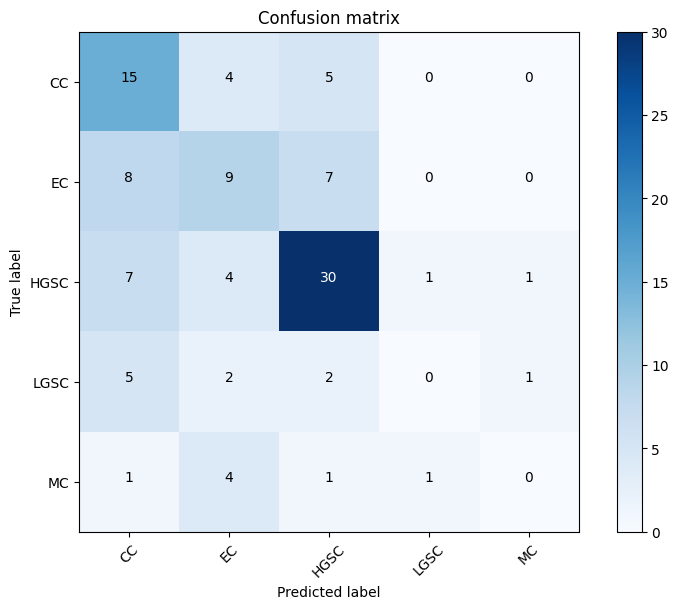

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_curves(train_acc, train_loss, val_acc, val_loss):
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_curves(train_acc, train_loss, val_acc, val_loss)
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# calculate predictions on the validation set
def get_all_preds(model, data_loader):
    all_preds = torch.tensor([]).to(device)
    all_targets = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            preds = model(images)
            all_preds = torch.cat(
                (all_preds, preds),
                dim=0
            )
            all_targets = torch.cat(
                (all_targets, labels),
                dim=0
            )
    return all_preds, all_targets

# get predictions and targets
val_preds, val_targets = get_all_preds(model, valid_data_loader)
val_preds = torch.argmax(val_preds, dim=1)

cm = confusion_matrix(val_targets.cpu(), val_preds.cpu())
plot_confusion_matrix(cm, classes)
print(classification_report(val_targets.cpu(), val_preds.cpu(), target_names=classes))


------------------------------------------------------------------------------------------------------------

# Model-2

**Fine-tuning**
- n_epochs: Number of epochs for training the model Value: 29
- lr: Learning rate for the optimizer (AdamW) Value: 0.0006
- batch_size: Batch size for training 32


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 29
total_step = len(train_data_loader)

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0006)  # Using AdamW optimizer
# preventing any single weight from becoming overly dominant -WT DECAY
weights_filename = 'baseline_resnet50.pt'

train_acc = []  
train_loss = []  
val_acc = []  
val_loss = []  

# training loop
for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f'\nEpoch {epoch+1}:')
    
    for batch_idx, (data_, target_) in enumerate(train_data_loader):        
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 8 == 0:  
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, batch_idx, total_step, loss.item()))
    
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'Train Loss: {np.mean(train_loss):.3f}, Train Acc: {(100 * correct / total):.1f}%')
    
    # validation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_data_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            
            val_running_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            val_correct += torch.sum(pred_t == target_t).item()
            val_total += target_t.size(0)
            
        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(valid_data_loader))

    print(f'Validation Loss: {np.mean(val_loss):.3f}, Validation Acc: {(100 * val_correct / val_total):.1f}%')
    torch.save(model.state_dict(), weights_filename)

    model.train()

print(f'\nFinal Training Loss: {np.mean(train_loss):.3f}, Final Training Acc: {(100 * correct / total):.1f}%')
print(f'Final Validation Loss: {np.mean(val_loss):.3f}, Final Validation Acc: {(100 * val_correct / val_total):.1f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1:
Epoch [1/29], Step [0/27], Loss: 1.5448
Epoch [1/29], Step [8/27], Loss: 1.8892
Epoch [1/29], Step [16/27], Loss: 1.7096
Epoch [1/29], Step [24/27], Loss: 1.3925
Train Loss: 1.451, Train Acc: 38.4%
Validation Loss: 1.368, Validation Acc: 43.5%

Epoch 2:
Epoch [2/29], Step [0/27], Loss: 1.2470
Epoch [2/29], Step [8/27], Loss: 1.4218
Epoch [2/29], Step [16/27], Loss: 1.4244
Epoch [2/29], Step [24/27], Loss: 1.3027
Train Loss: 1.371, Train Acc: 45.6%
Validation Loss: 1.344, Validation Acc: 44.4%

Epoch 3:
Epoch [3/29], Step [0/27], Loss: 1.2238
Epoch [3/29], Step [8/27], Loss: 1.4017
Epoch [3/29], Step [16/27], Loss: 1.4336
Epoch [3/29], Step [24/27], Loss: 1.2368
Train Loss: 1.319, Train Acc: 49.3%
Validation Loss: 1.322, Validation Acc: 48.1%

Epoch 4:
Epoch [4/29], Step [0/27], Loss: 1.1381
Epoch [4/29], Step [8/27], Loss: 1.3286
Epoch [4/29], Step [16/27], Loss: 1.3012
Epoch [4/29], Step [24/27], Loss: 1.1516
Train Loss: 1.280, Train Acc: 52.3%
Validation Loss: 1.305, Valida

In [43]:
torch.save(model, 'trained_resnet50_model_2.pth')

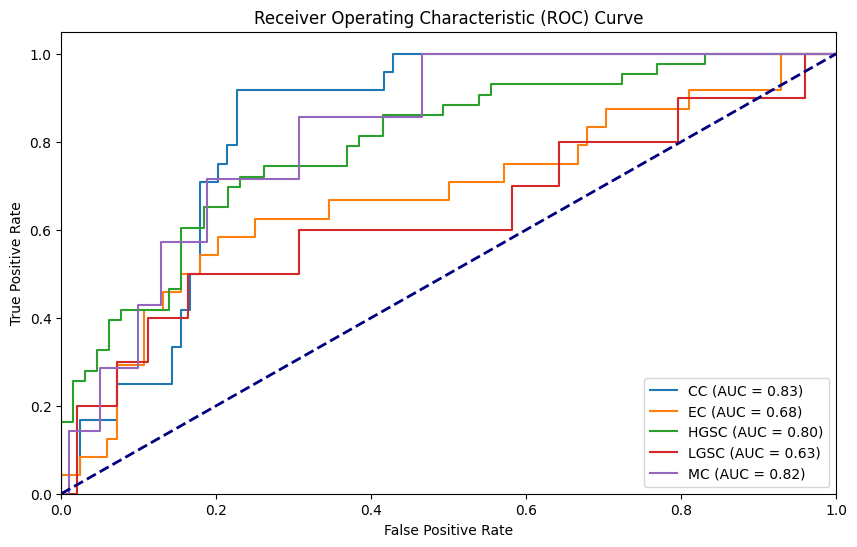

In [42]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted probabilities
true_labels = []
pred_probs = []

# Switch model to evaluation mode
model.eval()

# Iterate through the validation data loader to get predictions and true labels
with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        
        # Convert tensor to numpy array and append to lists
        true_labels.extend(target.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Initialize dictionary to store ROC AUC scores for each class
roc_auc_scores = {}

# Calculate ROC AUC scores for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

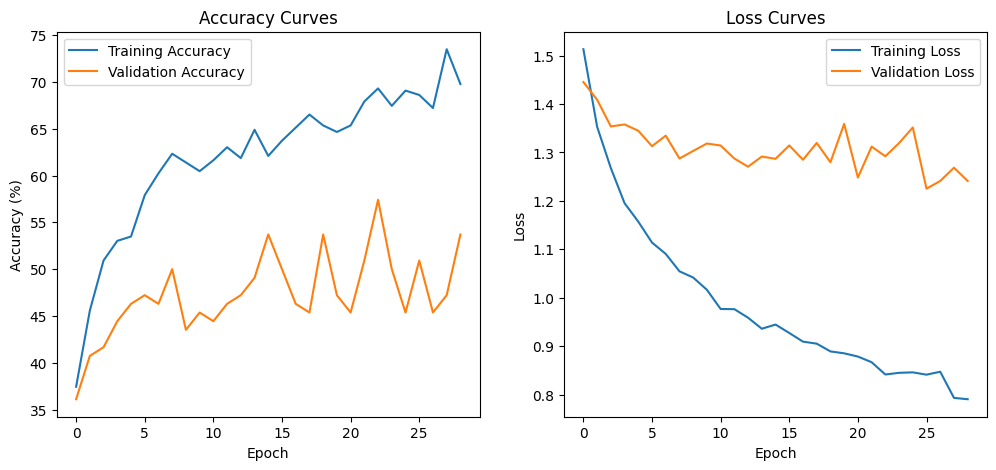

Classification Report:
              precision    recall  f1-score   support

          CC       0.55      0.61      0.58        18
          EC       0.27      0.30      0.29        23
        HGSC       0.59      0.60      0.60        48
        LGSC       0.33      0.09      0.14        11
          MC       0.20      0.25      0.22         8

    accuracy                           0.46       108
   macro avg       0.39      0.37      0.37       108
weighted avg       0.46      0.46      0.45       108



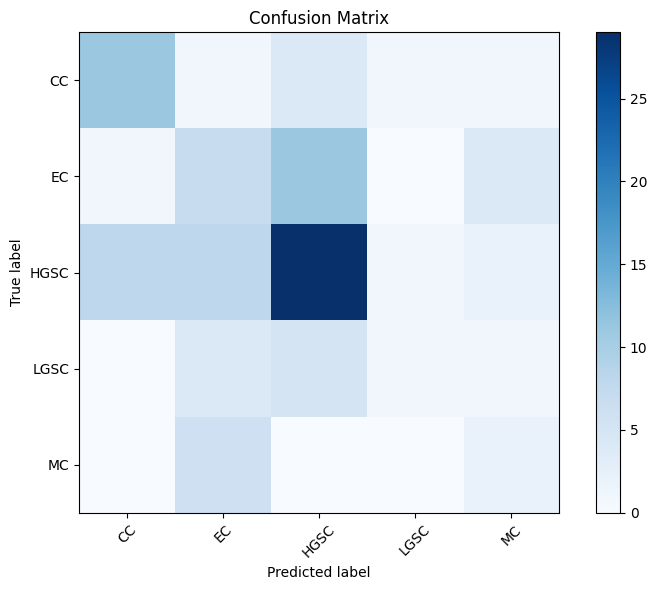

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training and validation curves
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Classification report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert class indices to class labels
class_labels = [classes[i] for i in range(len(classes))]

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


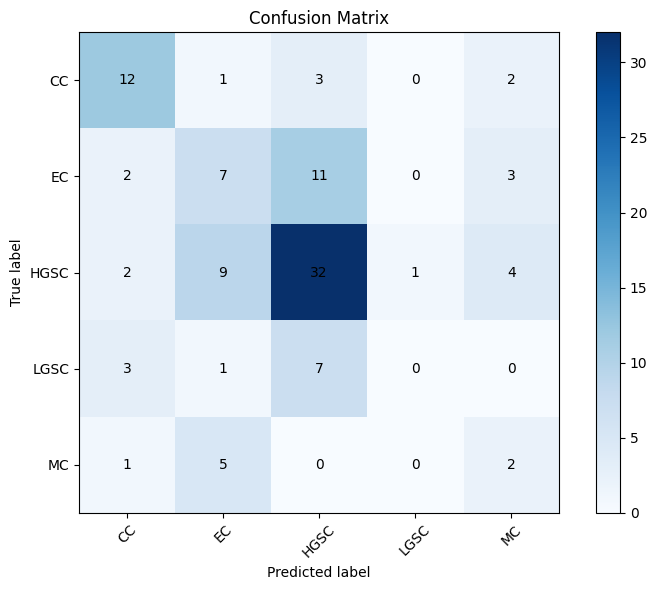

In [71]:
# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers inside the confusion matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', verticalalignment='center')

plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Model 3

-------------------------------------------------------------------------------------------------------

**Addressing overfitting**

- epochs Value: 29
- lr: Learning rate for the optimizer (AdamW) 0.0006
- weight_decay: Weight decay for L2 regularization 0.01

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 29
total_step = len(train_data_loader)
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model = model.to(device)

# optimizer and loss criteria with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.01)  # Adding weight decay for L2 regularization

weights_filename = 'baseline_resnet50.pt'

train_acc = []  # Initialize train_acc list
train_loss = []  # Initialize train_loss list
val_acc = []  # Initialize val_acc list
val_loss = []  # Initialize val_loss list

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f'\nEpoch {epoch+1}:')
    
    for batch_idx, (data_, target_) in enumerate(train_data_loader):        
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 8 == 0:  
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, batch_idx, total_step, loss.item()))
    
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'Train Loss: {np.mean(train_loss):.3f}, Train Acc: {(100 * correct / total):.1f}%')
    
    # Validation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_data_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            
            val_running_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            val_correct += torch.sum(pred_t == target_t).item()
            val_total += target_t.size(0)
            
        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(valid_data_loader))

    print(f'Validation Loss: {np.mean(val_loss):.3f}, Validation Acc: {(100 * val_correct / val_total):.1f}%')
    
    torch.save(model.state_dict(), weights_filename)

    # Set the model back to training mode
    model.train()

# Display final accuracy and loss
print(f'\nFinal Training Loss: {np.mean(train_loss):.3f}, Final Training Acc: {(100 * correct / total):.1f}%')
print(f'Final Validation Loss: {np.mean(val_loss):.3f}, Final Validation Acc: {(100 * val_correct / val_total):.1f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1:
Epoch [1/29], Step [0/27], Loss: 1.5905
Epoch [1/29], Step [8/27], Loss: 1.4299
Epoch [1/29], Step [16/27], Loss: 1.6086
Epoch [1/29], Step [24/27], Loss: 1.2967
Train Loss: 1.523, Train Acc: 37.4%
Validation Loss: 1.468, Validation Acc: 39.8%

Epoch 2:
Epoch [2/29], Step [0/27], Loss: 1.0096
Epoch [2/29], Step [8/27], Loss: 1.2468
Epoch [2/29], Step [16/27], Loss: 1.5373
Epoch [2/29], Step [24/27], Loss: 1.2648
Train Loss: 1.444, Train Acc: 44.2%
Validation Loss: 1.406, Validation Acc: 48.1%

Epoch 3:
Epoch [3/29], Step [0/27], Loss: 0.9708
Epoch [3/29], Step [8/27], Loss: 1.2685
Epoch [3/29], Step [16/27], Loss: 1.4289
Epoch [3/29], Step [24/27], Loss: 1.1882
Train Loss: 1.391, Train Acc: 48.8%
Validation Loss: 1.387, Validation Acc: 46.3%

Epoch 4:
Epoch [4/29], Step [0/27], Loss: 0.8560
Epoch [4/29], Step [8/27], Loss: 1.1732
Epoch [4/29], Step [16/27], Loss: 1.3540
Epoch [4/29], Step [24/27], Loss: 1.2090
Train Loss: 1.351, Train Acc: 51.2%
Validation Loss: 1.367, Valida

In [46]:
torch.save(model, 'trained_resnet50_model_3.pth')

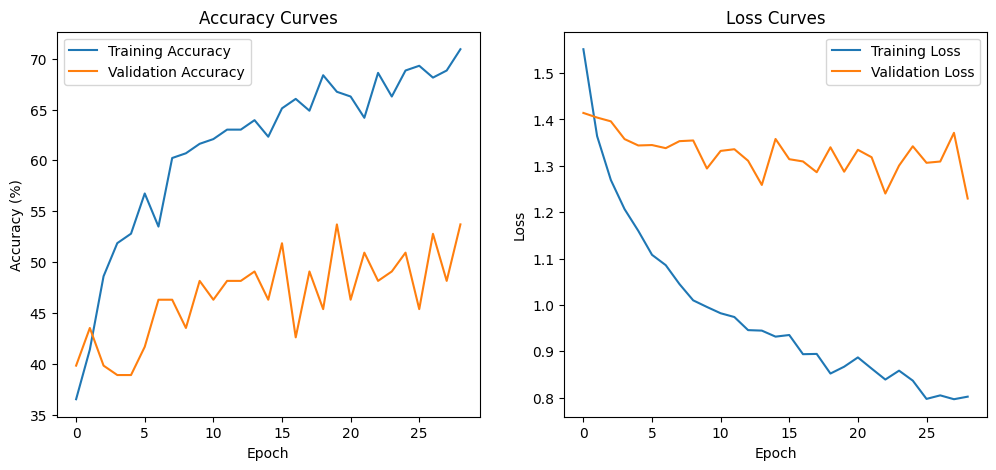

Classification Report:
              precision    recall  f1-score   support

          CC       0.50      0.56      0.53        18
          EC       0.33      0.35      0.34        23
        HGSC       0.58      0.60      0.59        48
        LGSC       0.50      0.18      0.27        11
          MC       0.30      0.38      0.33         8

    accuracy                           0.48       108
   macro avg       0.44      0.41      0.41       108
weighted avg       0.49      0.48      0.48       108



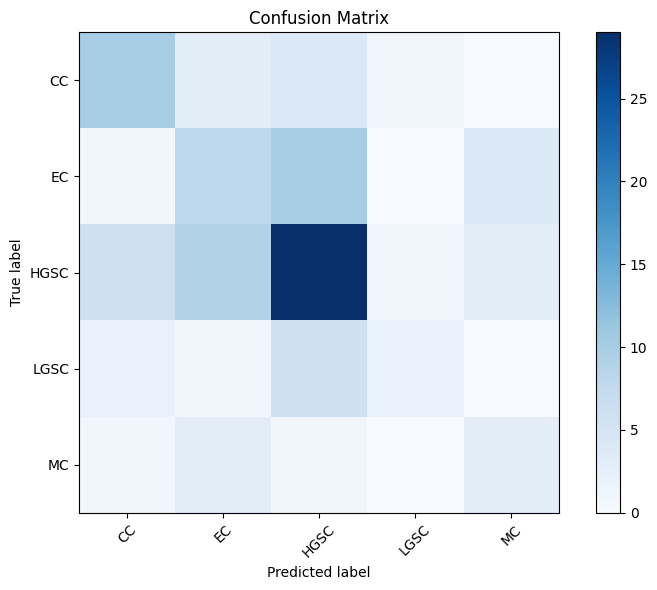

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training and validation curves
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Classification report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert class indices to class labels
class_labels = [classes[i] for i in range(len(classes))]

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [75]:
conf_matrix

array([[10,  3,  4,  1,  0],
       [ 1,  8, 10,  0,  4],
       [ 6,  9, 29,  1,  3],
       [ 2,  1,  6,  2,  0],
       [ 1,  3,  1,  0,  3]])

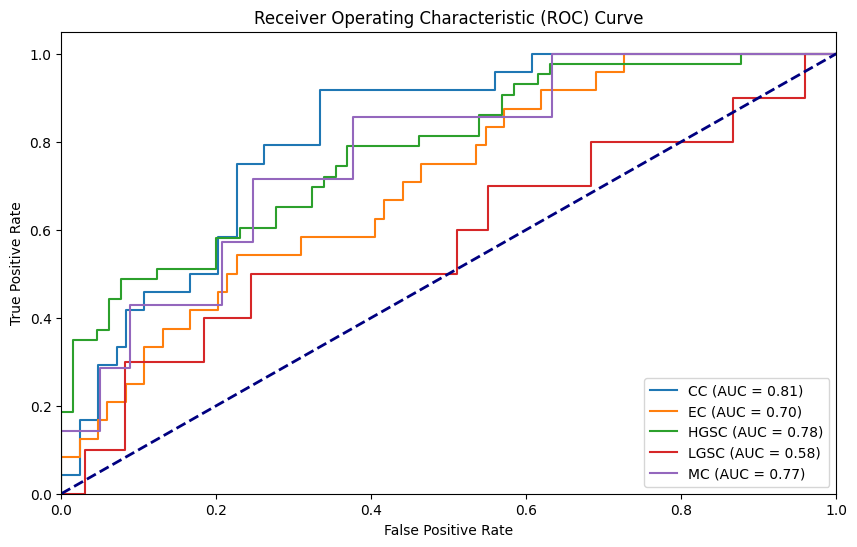

In [45]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted probabilities
true_labels = []
pred_probs = []

# Iterate through the validation data loader to get predictions and true labels
with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        
        # Convert tensor to numpy array and append to lists
        true_labels.extend(target.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Initialize dictionary to store ROC AUC scores for each class
roc_auc_scores = {}

# Calculate ROC AUC scores for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[classes[i]] = roc_auc
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


---------------------------------------------------------------------------------------------------------

# Model 4

In [47]:
import torchvision.transforms as transforms

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),   
    transforms.RandomRotation(10),       
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.ToTensor(),               
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
])

# Define dropout layer
dropout = nn.Dropout(p=0.5)  # Dropout with probability 0.5

# training loop with data augmentation and dropout
for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f'\nEpoch {epoch+1}:')
    
    for batch_idx, (data_, target_) in enumerate(train_data_loader):        
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()
        outputs = model(data_)
        outputs = dropout(outputs)  # Apply dropout
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 8 == 0:  
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, batch_idx, total_step, loss.item()))
    
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'Train Loss: {np.mean(train_loss):.3f}, Train Acc: {(100 * correct / total):.1f}%')
    
    # Validation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_data_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            
            val_running_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            val_correct += torch.sum(pred_t == target_t).item()
            val_total += target_t.size(0)
            
        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(valid_data_loader))

    print(f'Validation Loss: {np.mean(val_loss):.3f}, Validation Acc: {(100 * val_correct / val_total):.1f}%')
    torch.save(model.state_dict(), weights_filename)
    model.train()

print(f'\nFinal Training Loss: {np.mean(train_loss):.3f}, Final Training Acc: {(100 * correct / total):.1f}%')
print(f'Final Validation Loss: {np.mean(val_loss):.3f}, Final Validation Acc: {(100 * val_correct / val_total):.1f}%')



Epoch 1:
Epoch [1/29], Step [0/27], Loss: 1.2409
Epoch [1/29], Step [8/27], Loss: 1.0421
Epoch [1/29], Step [16/27], Loss: 1.0754
Epoch [1/29], Step [24/27], Loss: 1.5343
Train Loss: 0.977, Train Acc: 46.0%
Validation Loss: 1.253, Validation Acc: 45.4%

Epoch 2:
Epoch [2/29], Step [0/27], Loss: 1.2439
Epoch [2/29], Step [8/27], Loss: 1.5635
Epoch [2/29], Step [16/27], Loss: 1.2103
Epoch [2/29], Step [24/27], Loss: 1.2116
Train Loss: 0.985, Train Acc: 46.5%
Validation Loss: 1.258, Validation Acc: 46.3%

Epoch 3:
Epoch [3/29], Step [0/27], Loss: 1.2559
Epoch [3/29], Step [8/27], Loss: 0.8704
Epoch [3/29], Step [16/27], Loss: 1.0921
Epoch [3/29], Step [24/27], Loss: 0.8818
Train Loss: 0.988, Train Acc: 51.9%
Validation Loss: 1.257, Validation Acc: 52.8%

Epoch 4:
Epoch [4/29], Step [0/27], Loss: 1.0516
Epoch [4/29], Step [8/27], Loss: 1.2020
Epoch [4/29], Step [16/27], Loss: 0.8326
Epoch [4/29], Step [24/27], Loss: 1.1263
Train Loss: 0.990, Train Acc: 54.0%
Validation Loss: 1.259, Valida

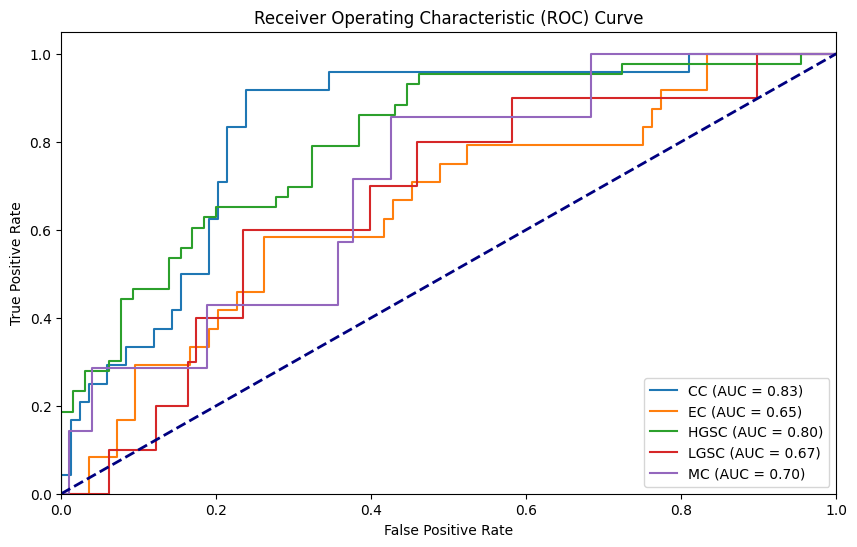

              precision    recall  f1-score   support

          CC       0.49      0.83      0.62        24
          EC       0.32      0.33      0.33        24
        HGSC       0.73      0.51      0.60        43
        LGSC       0.10      0.10      0.10        10
          MC       0.00      0.00      0.00         7

    accuracy                           0.47       108
   macro avg       0.33      0.36      0.33       108
weighted avg       0.48      0.47      0.46       108



In [48]:
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted probabilities
true_labels = []
pred_probs = []

# Iterate through the validation data loader to get predictions and true labels
with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        
        # Convert tensor to numpy array and append to lists
        true_labels.extend(target.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Initialize dictionary to store ROC AUC scores for each class
roc_auc_scores = {}

# Calculate ROC AUC scores for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[classes[i]] = roc_auc
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display the classification report
pred_labels = np.argmax(pred_probs, axis=1)
print(classification_report(true_labels, pred_labels, target_names=classes))


In [50]:
torch.save(model, 'trained_resnet50_model_4.pth')

----------------------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

          CC       0.59      0.56      0.57        18
          EC       0.25      0.13      0.17        23
        HGSC       0.62      0.75      0.68        48
        LGSC       0.40      0.55      0.46        11
          MC       0.50      0.38      0.43         8

    accuracy                           0.54       108
   macro avg       0.47      0.47      0.46       108
weighted avg       0.50      0.54      0.51       108



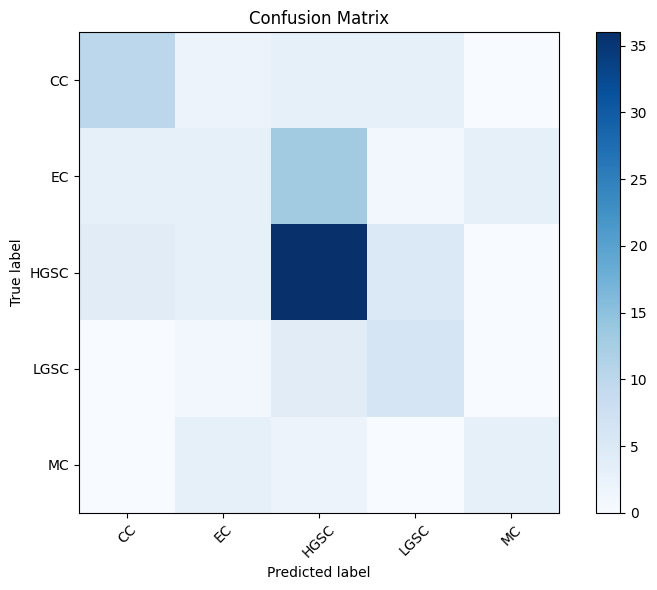

In [78]:
# Classification report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert class indices to class labels
class_labels = [classes[i] for i in range(len(classes))]

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Model 5

**Fine Tuning**
- lr: 0.00001 for sgd
- momentum: 0.6
- weight_decay: 1e-5
- dropout: 0.2
- num_epochs: 2

Epoch [1/2], Train Loss: 1.0677, Train Acc: 57.91%
Epoch [1/2], Validation Loss: 1.2317, Validation Acc: 53.70%
Epoch [2/2], Train Loss: 1.0863, Train Acc: 55.81%
Epoch [2/2], Validation Loss: 1.2210, Validation Acc: 46.30%


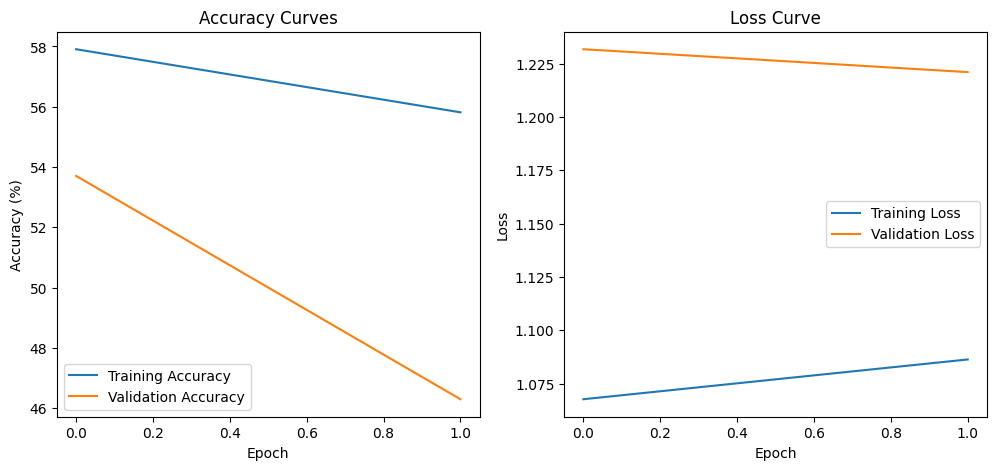

In [51]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model = torch.load('trained_resnet50_model.pth')
saved_model = saved_model.to(device)

for param in saved_model.layer4.parameters():
    param.requires_grad = True

optimizer_ft = optim.SGD(saved_model.parameters(), lr=0.00001, momentum=0.6, weight_decay=1e-5)  # Adding weight decay for L2 regularization
criterion = nn.CrossEntropyLoss()
dropout = nn.Dropout(p=0.2)  # Adding dropout with probability 0.2
# Fine-tuning loop
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []
    val_loss_list = []  
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            outputs = dropout(outputs)  # Apply dropout
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred == target).item()
            total += target.size(0)
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_data_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

        val_acc, val_loss = evaluate_model(model, criterion)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)  # Store validation loss
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')
    
    return train_loss_list, train_acc_list, val_acc_list, val_loss_list

def evaluate_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data, target in valid_data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred == target).item()
            total += target.size(0)
            val_loss += criterion(outputs, target).item()
    val_acc = 100 * correct / total
    val_loss /= len(valid_data_loader)
    return val_acc, val_loss

train_loss_list, train_acc_list, val_acc_list, val_loss_list = train_model(saved_model, criterion, optimizer_ft, num_epochs=2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


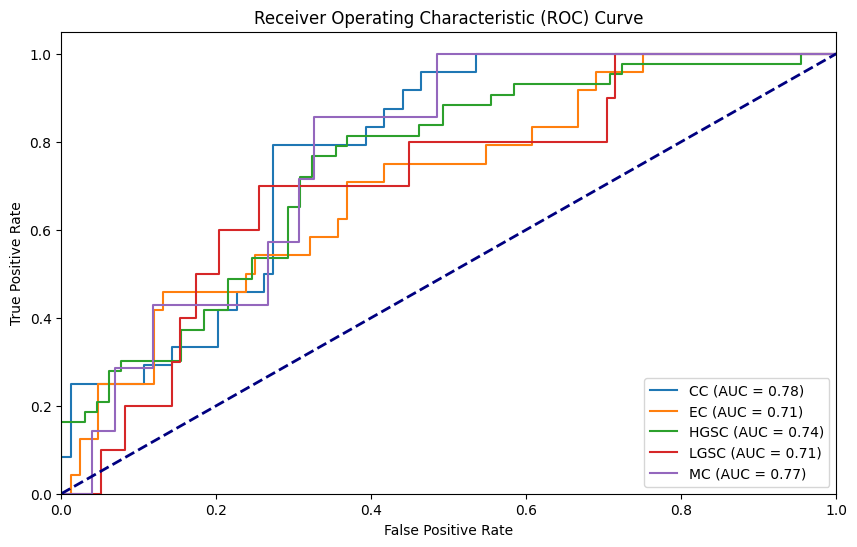

In [52]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to evaluate the model and return predicted probabilities
def evaluate_model_with_prob(model, criterion):
    model.eval()
    all_preds = []
    all_targets = []
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in valid_data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            val_loss += criterion(outputs, target).item()
            probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
            all_preds.append(probabilities.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    val_loss /= len(valid_data_loader)
    return all_preds, all_targets, val_loss

# Calculate predicted probabilities and get true labels
pred_probs, true_labels, val_loss = evaluate_model_with_prob(saved_model, criterion)

# Initialize dictionary to store ROC AUC scores for each class
roc_auc_scores = {}

# Plot ROC AUC curves for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc_scores[classes[i]] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc_scores[classes[i]]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [53]:
import torch

torch.save(saved_model.state_dict(), 'fine_tuned_resnet50_model_5.pth')


---------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

# **Making Predictions**

In [ ]:
#predictions
class TestImageLoader(Dataset):
    def __init__(self, data, root_path, test_thumbnails, transform=None):
        self.data = data
        self.root_path = root_path
        self.test_thumbnails = test_thumbnails
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, -1]
        path = os.path.join(root_path, self.test_thumbnails, img_name)

        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image

In [100]:
#predictions
class TestImageLoader(Dataset):
    def __init__(self, data, root_path, test_thumbnails, transform=None):
        self.data = data
        self.root_path = root_path
        self.test_thumbnails = test_thumbnails
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, -1]
        path = os.path.join(root_path, self.test_thumbnails, img_name)

        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image
model = torch.load('trained_resnet50_model_3.pth', map_location=device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [101]:
class TestImageLoader(Dataset):
    def __init__(self, data, root_path, test_thumbnails, transform=None):
        self.data = data
        self.root_path = root_path
        self.test_thumbnails = test_thumbnails
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, -1]
        path = os.path.join(root_path, self.test_thumbnails, img_name)

        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image
test_data = TestImageLoader(test, root_path, test_thumbs, valid_transform)
test_data_loader = DataLoader(test_data, batch_size = 32, shuffle = False, num_workers = 4)
y_pred = []
for inputs in test_data_loader:
    inputs = inputs.to(device)
    output = model(inputs)
    
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

In [102]:

y_pred = []
for inputs in test_data_loader:
    inputs = inputs.to(device)
    output = model(inputs)
    
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

In [103]:

print("Our test data belongs to class: ", laben.inverse_transform(y_pred)[0])

Our test data belongs to class:  HGSC


In [103]:
test

,image_id,image_width,image_height,image_id_path
0,41,28469,16987,41_thumbnail.png


In [70]:
test_df

,image_id,label,image_width,image_height,is_tma,image_id_path
295,35998,HGSC,30900,29909,False,35998_thumbnail.png
434,52108,EC,16621,14700,False,52108_thumbnail.png
362,43280,EC,79191,29689,False,43280_thumbnail.png
354,41368,EC,3388,3388,True,41368.png
473,56799,MC,51304,33963,False,56799_thumbnail.png
28,3092,LGSC,38308,20600,False,3092_thumbnail.png
223,27747,HGSC,47487,28122,False,27747_thumbnail.png
371,44283,CC,20903,24764,False,44283_thumbnail.png
36,3997,MC,49467,29610,False,3997_thumbnail.png
49,5307,HGSC,71975,27683,False,5307_thumbnail.png


# Testing the model on test data

In [73]:
test_df

,image_id,label,image_width,image_height,is_tma,image_id_path
295,35998,HGSC,30900,29909,False,35998_thumbnail.png
434,52108,EC,16621,14700,False,52108_thumbnail.png
362,43280,EC,79191,29689,False,43280_thumbnail.png
354,41368,EC,3388,3388,True,41368.png
473,56799,MC,51304,33963,False,56799_thumbnail.png
28,3092,LGSC,38308,20600,False,3092_thumbnail.png
223,27747,HGSC,47487,28122,False,27747_thumbnail.png
371,44283,CC,20903,24764,False,44283_thumbnail.png
36,3997,MC,49467,29610,False,3997_thumbnail.png
49,5307,HGSC,71975,27683,False,5307_thumbnail.png


In [106]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

# Define the TestImageLoader class
class TestImageLoader(Dataset):
    def __init__(self, data, root_path, transform=None):
        self.data = data
        self.root_path = root_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id_path']
        img_path = os.path.join(self.root_path, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


root_path = "/kaggle/input/UBC-OCEAN/train_thumbnails"  # Replace with the path to your image directory
test_dataset = TestImageLoader(test_df, root_path, transform=valid_transform)

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.to(device)  # Move model to the appropriate device (GPU or CPU)

# Load the saved model state dictionary
model_dict = torch.load('/kaggle/working/baseline_resnet50.pt')
model.load_state_dict(model_dict)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Make predictions
y_pred = []
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.item())

# Map predicted labels to their corresponding class names
label_map = {2: 'HGSC', 1: 'EC', 4: 'MC', 0: 'CC', 3: 'LGSC'}
test_df['predicted_label'] = [label_map[p] for p in y_pred]

# Display predictions
print(test_df[['image_id', 'label', 'predicted_label']])


     image_id label predicted_label
532     64950  HGSC            HGSC
466     55281  HGSC            HGSC
157     18607    EC              EC
22       2391  LGSC            HGSC
456     54007  HGSC            HGSC
156     18568  HGSC            HGSC
128     15293  HGSC              EC
479     57100  HGSC            HGSC
12       1289  HGSC            HGSC
133     15742    EC              EC


In [107]:
from sklearn.metrics import classification_report
actual_labels = test_df['label'].tolist()
predicted_labels = test_df['predicted_label'].tolist()
report = classification_report(actual_labels, predicted_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

          EC       0.67      1.00      0.80         2
        HGSC       0.86      0.86      0.86         7
        LGSC       0.00      0.00      0.00         1

    accuracy                           0.80        10
   macro avg       0.51      0.62      0.55        10
weighted avg       0.73      0.80      0.76        10



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
from sklearn.metrics import accuracy_score
# Map predicted labels to their corresponding class names
label_map = {2: 'HGSC', 1: 'EC', 4: 'MC', 0: 'CC', 3: 'LGSC'}
test_df['predicted_label'] = [label_map[p] for p in y_pred]

# Calculate accuracy score
accuracy = accuracy_score(test_df['label'], test_df['predicted_label'])
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 80.00%


------------------------------------------------------------------------------------------------------------

In [139]:
predicted_label

'LGSC'